<a href="https://colab.research.google.com/github/natbugreal/datascience/blob/main/NataPereU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# The Data Set

I'm making a simple model to look at total rebounds (TRB) based on player positions using basketball stats from 573 players. You can see a quick look at the data below.

In [ ]:
# importing basketball data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"
# making position a categorical variable so that we can group by position
data = pd.read_csv(url,dtype={'Pos':'category'})

# keeping only the relevant columns
data = data[['PL', 'PS', 'RBT']]
data

,Player,Pos,TRB
0,Precious Achiuwa,PF-C,487
1,Bam Adebayo,C,737
2,Ochai Agbaji,SG,216
3,Santi Aldama,PF,352
4,Nickeil Alexander-Walker,SG,167
...,...,...,...
567,Thaddeus Young,PF,103
568,Trae Young,PG,149
569,Omer Yurtseven,C,208
570,Cody Zeller,C,112


In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = data.Pos.cat.codes.values

#an array of the strings that represent positions
pos_codes = data.Pos.cat.categories

#puts coords in as dict, so pymc can read them
bask_coords = {"PS": pos_codes}

# The Model

If we visualize the data in a violin plot, it looks like this. At first glance, it appears to be skewed right (positive skew). This informed my first shot at the model. I made a hierarchal model with SkewNormal.

<Axes: ylabel='TRB'>

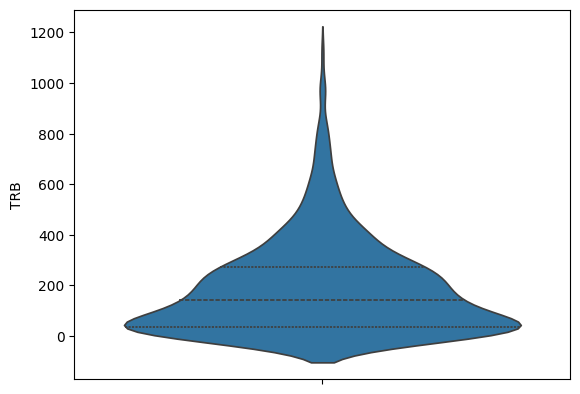

In [ ]:
# visualizing data
sns.violinplot(data.TRB,inner='qrt')

This is the Skew Normal model before breaking it down by position. I wanted to check if the model worked well overall. While there were some differences, it still ran. However, when I plotted my posterior predictive check, it didn't match up very well, suggesting that an exponential model might fit better.


In [ ]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)

    #priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd)

    σ = pm.HalfNormal('σ', sigma = 10)

    α = pm.Exponential('α', lam = 5)

    #skewnormal
    _ = pm.SkewNormal('trb', mu = μ, sigma = σ, alpha = α, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

<Axes: xlabel='trb'>

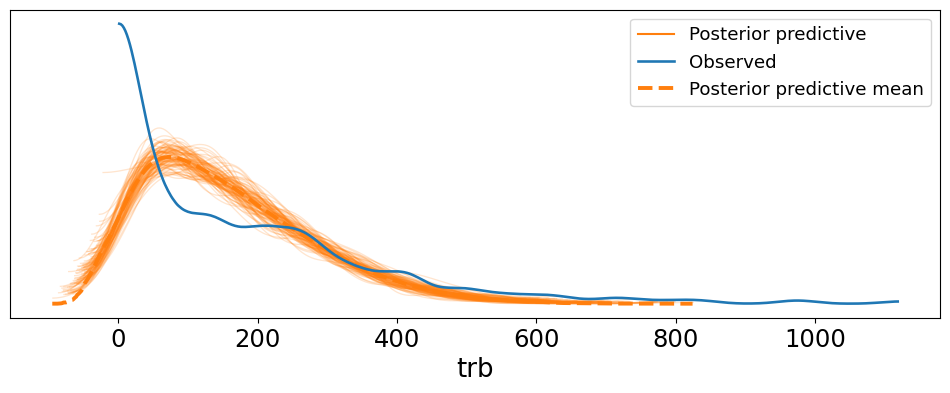

In [ ]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

After checking the Skew Normal model, I realized that the data fits an exponential model better, so I decided to try that one. You can see it below. I still haven't sorted it by position yet. This new model had no issues and worked much better than the Skew Normal model.


In [ ]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)

    #exponential
    _ = pm.Exponential('trb', lam = λ, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

(0.0, 1100.0)

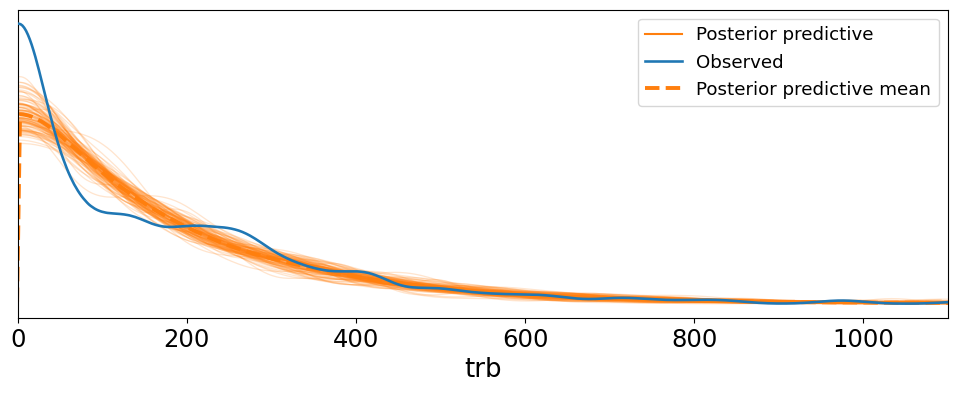

In [ ]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

Now that the model was fitting better, I broke down the posterior by position, giving each position its own prior while still using common hyperpriors for all of them. This model also had no issues at all.


In [ ]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "PS")

    #skewnormal
    _ = pm.Exponential('RBT', lam = λ[pos_idx], observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

# Analysis

When I created trace plots for the parameters of the inference data, I had to adjust the x-axis for λ to make it easier to read. You can see these trace plots below for the exponential model sorted by position. In the λ plot, some positions have clear peaks, while others are more flat and spread out. We'll see this again in the forest plot.


(0.0, 0.015)

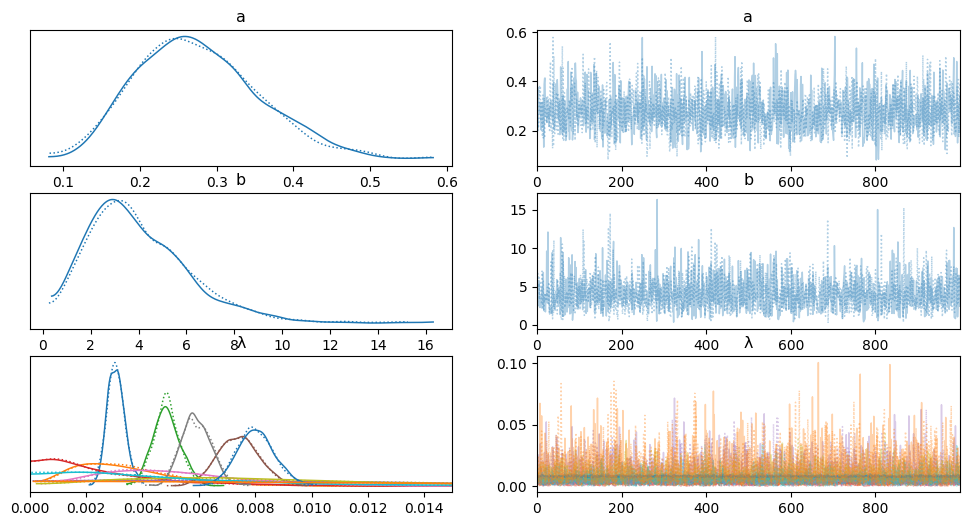

In [ ]:
#az.plot_trace(idata_bask) but limiting the graph of the λ so it is easier to read
az.plot_trace(idata_bask)[2,0].set_xlim([0, .015])

Below, you can see rhat values that are close to ideal.

In [ ]:
az.rhat(idata_bask) #ideally between 1 and 1.001. values above 1.1 are bad

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 0.9995
    b        float64 8B 1.001
    λ        (pos) float64 96B 1.001 1.001 1.003 0.9995 ... 1.001 1.001 0.9997

In [ ]:
#retrieving the array of means

posterior = idata_bask.posterior
lambda_variable = posterior['λ']
mean_lambda = lambda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lambda.values

#print(mean_array)

#creating the array of reciprocals

reciprocal_array = []
for value in mean_array:
    reciprocal = 1 / value
    reciprocal_array.append(reciprocal)

#print (reciprocal_array)

# go through each of the positions and print it next to the 1/lamda
# print(pos_codes)
for i in range(len(pos_codes)):
    position = pos_codes[i]
    reciprocal = reciprocal_array[i]
    print(f'{position}: {reciprocal}')

C: 327.27371124565803
C-PF: 293.37389655150696
PF: 205.519557212845
PF-C: 382.5337227437061
PF-SF: 87.49930222310344
PG: 134.92968491301528
PG-SG: 194.2665603715306
SF: 168.79516709994033
SF-PF: 110.91816056118525
SF-SG: 207.05774429359727
SG: 124.61725816263022
SG-PG: 65.97998091796983


bar graph

<BarContainer object of 12 artists>

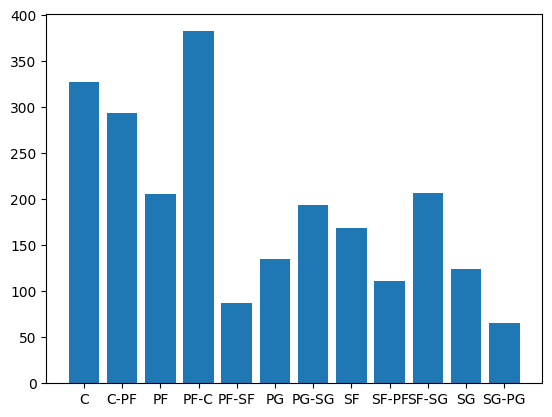

In [ ]:
plt.bar(ps_codes, reciprocal_array)

I believe our model is doing a good job at representing the the total rebounds for each postion, considering the average total rebounds for each position and the difference in each position.